# Import Libraries

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import svm
from sklearn import tree
from sklearn.tree import _tree
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score

# Importing and Creating Training & Testing Sets


In [3]:
original_train = pd.read_csv('../train.csv',header = 0)
original_train['dataset'] = 'train'
print original_train.shape

(10886, 13)


In [4]:
original_test = pd.read_csv('../test.csv',header = 0)
original_test['dataset'] = 'test'
print original_test.shape

(6493, 10)


In [5]:
df_complete =  original_train.copy().append(original_test.copy())
df_complete = df_complete.drop(['count'], axis = 1)

In [6]:
#add the counts as logarithms
df_complete['log_casual'] = df_complete['casual'].apply(np.log1p)
df_complete['log_registered'] = df_complete['registered'].apply(np.log1p)

In [7]:
# Make the datetime the index
df_complete['datetime'] = pd.to_datetime(df_complete['datetime'])

df_complete.index = df_complete['datetime']
del df_complete['datetime']

In [8]:
# Make sure we have all the complete values of the series
idx = pd.date_range('2011-01-01 00:00:00', '2012-12-31 23:00:00', freq='H')
df_complete = df_complete.reindex(idx)

In [9]:
#Put the target variables at the beggining
df_complete = df_complete[[u'casual', u'registered', u'log_casual', u'log_registered', u'dataset',  
       u'atemp', u'humidity', u'temp', u'windspeed', u'weather', u'season', u'workingday', u'holiday']]

In [10]:
# Missing entries? let's try to interpolate to get that info
missing = df_complete[pd.isnull(df_complete['atemp'])]
missing.shape

(165, 13)

In [11]:
df_complete["weather"] = df_complete["weather"].interpolate(method='time').apply(np.round)
df_complete["temp"] = df_complete["temp"].interpolate(method='time')
df_complete["atemp"] = df_complete["atemp"].interpolate(method='time')
df_complete["humidity"] = df_complete["humidity"].interpolate(method='time').apply(np.round)
df_complete["windspeed"] = df_complete["windspeed"].interpolate(method='time')
df_complete["season"] = df_complete["season"].interpolate(method='time').apply(np.round)
df_complete["workingday"] = df_complete["workingday"].interpolate(method='time').apply(np.round)
df_complete["holiday"] = df_complete["holiday"].interpolate(method='time').apply(np.round)

In [12]:
# If 0 rows then we don't have more missing
missing2 = df_complete[pd.isnull(df_complete['atemp'])]
missing2.shape

(0, 13)

# Initial Data View

In [13]:
df_complete[df_complete['dataset'] == 'train'].describe()

casual    registered    log_casual  log_registered         atemp  \
count  10886.000000  10886.000000  10886.000000    10886.000000  10886.000000   
mean      36.021955    155.552177      2.712439        4.395774     23.655084   
std       49.960477    151.039033      1.491055        1.399383      8.474601   
min        0.000000      0.000000      0.000000        0.000000      0.760000   
25%        4.000000     36.000000      1.609438        3.610918     16.665000   
50%       17.000000    118.000000      2.890372        4.779123     24.240000   
75%       49.000000    222.000000      3.912023        5.407172     31.060000   
max      367.000000    886.000000      5.908083        6.787845     45.455000   

           humidity         temp     windspeed       weather        season  \
count  10886.000000  10886.00000  10886.000000  10886.000000  10886.000000   
mean      61.886460     20.23086     12.799395      1.418427      2.506614   
std       19.245033      7.79159      8.164537      0.633839      1.116174   
min        0.000000      0.82000      0.000000      1.000000      1.000000   
25%       47.000000     13.94000      7.001500      1.000000      2.000000   
50%       62.000000     20.50000     12.998000      1.000000      3.000000   
75%       77.000000     26.24000     16.997900      2.000000      4.000000   
max      100.000000     41.00000     56.996900      4.000000      4.000000   

         workingday       holiday  
count  10886.000000  10886.000000  
mean       0.680875      0.028569  
std        0.466159      0.166599  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        1.000000      0.000000  
75%        1.000000      0.000000  
max        1.000000      1.000000

D:\Software\Anaconda2\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


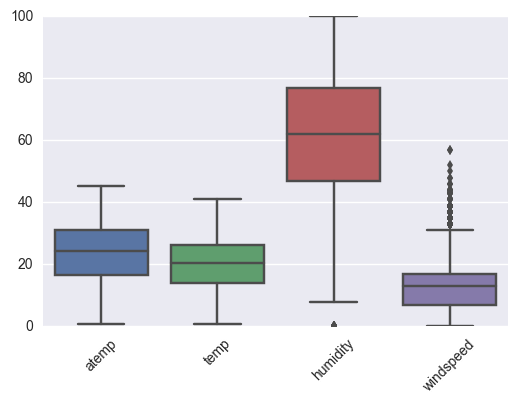

In [14]:
plot_cols = ['atemp', 'temp', 'humidity', 'windspeed']
boxplot = sns.boxplot(df_complete[df_complete['dataset'] == 'train'][ plot_cols])
for item in boxplot.get_xticklabels():
    item.set_rotation(45)

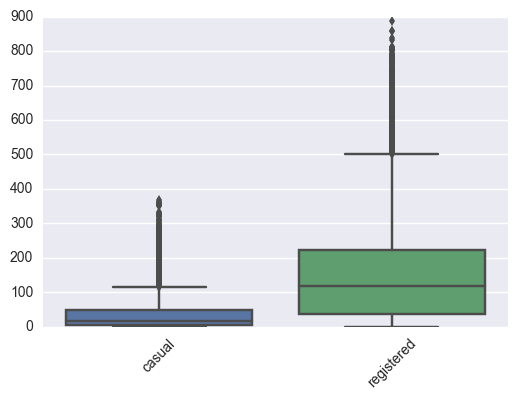

In [15]:
plot_cols = ['casual', 'registered']
boxplot = sns.boxplot(df_complete[df_complete['dataset'] == 'train'][plot_cols])
for item in boxplot.get_xticklabels():
    item.set_rotation(45)

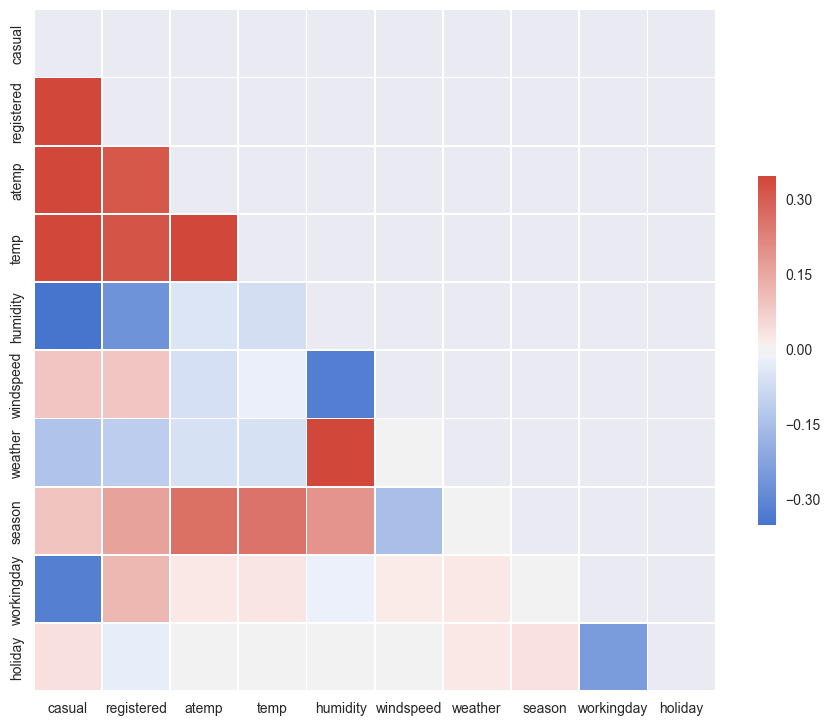

In [67]:
# Compute the correlation matrix
plot_cols = ['casual', 'registered', 'atemp', 'temp', 'humidity', 'windspeed', 'weather',
             'season', 'workingday', 'holiday']
corr = df_complete[df_complete['dataset'] == 'train'][plot_cols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(256, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [17]:
df_complete[df_complete['dataset'] == 'train'].dtypes

casual            float64
registered        float64
log_casual        float64
log_registered    float64
dataset            object
atemp             float64
humidity          float64
temp              float64
windspeed         float64
weather           float64
season            float64
workingday        float64
holiday           float64
dtype: object

In [18]:
df_complete[df_complete['dataset'] == 'train'].shape

(10886, 13)

# Utils

In [19]:
# Function that prints the prediction according the submission format
def printPrediction(pred, fileName='pred.csv'):
    str_prediction = "datetime,count\n"
    for i in range(0, len(pred)):
        datetime = original_test['datetime'][i]
        currentPred = int(round(pred[i]))
        str_prediction += "{},{}\n".format(datetime, currentPred)

    #print str_prediction
    f = open(fileName,'w')
    f.write(str_prediction)
    f.close()

In [20]:
# Function that gets the range of an specific day
def get_day_range(day):
    day_end = day + pd.offsets.DateOffset(hours=23)
    return pd.date_range(day, day_end, freq="H")

In [21]:
# Function that returns the correct sum of casual and registered rentals taking into account if log is being used
def getSumRentals(casual, registered, use_log):
    if(use_log):
        return np.expm1(casual) + np.expm1(registered)
    else:
        return casual + registered

In [24]:
#Function that predicts the number of rentals for an specific model
# The prediction is done independently for casual and predicted features, as well as for the years (2011, 2012)
# It returns the sum of the casual and registered predictions
def predictWithModel(model, train_x, train_y_c, train_y_r, test_x, features_casual, features_registered, use_log):
    train_pred_c = []
    train_pred_r = []
    
    test_pred_c = []
    test_pred_r = []

    years = [2011, 2012]
    for y in years:
        # print 'Predicting: {}'.format(y)
        train_mask = (train_x['year'] == y)
        train_mask = train_mask.values

        test_mask = (test_x['year'] == y)
        test_mask = test_mask.values


        model.fit(train_x[train_mask][features_casual], train_y_c[train_mask])
        train_pred_c_current = np.array(model.predict(train_x[train_mask][features_casual]))
        train_pred_c = np.concatenate((train_pred_c, train_pred_c_current), axis = 0)
        test_pred_c_current = np.array(model.predict(test_x[test_mask][features_casual]))
        test_pred_c = np.concatenate((test_pred_c, test_pred_c_current), axis = 0)

        model.fit(train_x[train_mask][features_registered], train_y_r[train_mask])
        train_pred_r_current = np.array(model.predict(train_x[train_mask][features_registered]))
        train_pred_r = np.concatenate((train_pred_r, train_pred_r_current), axis = 0)
        test_pred_r_current = np.array(model.predict(test_x[test_mask][features_registered]))
        test_pred_r = np.concatenate((test_pred_r, test_pred_r_current), axis = 0)
    
    return getSumRentals(train_pred_c, train_pred_r, use_log), getSumRentals(test_pred_c, test_pred_r, use_log) 

In [25]:
# Funciton that produces the code for the rules of a Decision Tree
def tree_to_code(sk_tree, feature_names):
    tree_ = sk_tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print "def sk_tree({}):".format(", ".join(feature_names))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print "{}if {} <= {}:".format(indent, name, threshold)
            recurse(tree_.children_left[node], depth + 1)
            print "{}else:  # if {} > {}".format(indent, name, threshold)
            recurse(tree_.children_right[node], depth + 1)
        else:
            print "{}return {}".format(indent, tree_.value[node])

    recurse(0, 1)

In [26]:
#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [27]:
#Function for parameter tuning inding best parameters
def parameterTunning(regressionModel, tuned_parameters, X_train, X_test, y_train, y_test):

    clf = GridSearchCV(regressionModel, tuned_parameters, cv=5, scoring='r2')
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    
    #best_estimator_ returns the best estimator chosen by the search
    print(clf.best_estimator_)
    print ""
    print("Grid scores on development set:")
    print ""
    #grid_scores_ returns:
    #    * a dict of parameter settings
    #    * the mean score over the cross-validation folds 
    #    * the list of scores for each fold
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print ""

In [28]:
#Function that splits a dataset into train and test sets
def splitTrainingTesting(df_full, use_log, test_size = 0.3):
    
    train, test = cross_validation.train_test_split(df_full, test_size = test_size)
    
    train = train.sort_index()
    test = test.sort_index()
    
    train_x = train.drop(['casual', 'registered', 'log_casual', 'log_registered'],axis = 1)
    train_y_c = train['log_casual'].values if use_log else train['casual'].values
    train_y_r = train['log_registered'].values if use_log else train['registered'].values
    
    test_x = test.drop(['casual', 'registered', 'log_casual', 'log_registered'],axis = 1)
    test_y_c = test['log_casual'].values if use_log else test['casual'].values
    test_y_r = test['log_registered'].values if use_log else test['registered'].values
    
    return train_x, train_y_c, train_y_r, test_x, test_y_c, test_y_r

In [29]:
#Function that runs 3-fold crossvalidation given a model
def crossValidationForModel(model, x, y_c, y_r, features_casual, features_registered, use_log, crossValidationGenerator):
    y = getSumRentals(y_c, y_r, use_log)
    for train, val in crossValidationGenerator:
        
        train = np.sort(train)
        val = np.sort(val)
        
        train_pred, val_pred = predictWithModel(model, x.iloc[train], y_c[train], y_r[train], x.iloc[val], 
                                features_casual, features_registered, use_log)
        train_y = y[train]
        train_score = rmsle(train_y, train_pred)
        
        val_y = y[val]
        val_score = rmsle(val_y, val_pred)
        
        print("Train RMSLE: {0:.3f}, Validation RMSLE: {1:.3f}\n".format(train_score, val_score))

In [30]:
# Function that groups the values of a series according to an interval so a plot can be drawn more clearly
def getGraphAxisByIntervals(series, interval):
    byIntervals = pd.DataFrame()
    series_r = series.reset_index()
    cols = series_r.columns
    min_val = int(min(series_r[cols[0]]))
    max_val = math.ceil(max(series_r[cols[0]]))
    
    stop = False
    prev_val = min_val
    next_val = min_val + interval
    while not stop:
        #Hotfix to include certain values
        prev_val = prev_val - 0.000001
        
        if next_val >= max_val:
            next_val = max_val
            stop = True
        
        current_sum = sum(series_r[cols[1]][(series_r[cols[0]] > prev_val) & (series_r[cols[0]] <= next_val)])
        byIntervals = byIntervals.append(pd.DataFrame([[next_val, current_sum]], columns=cols))
        
        
        prev_val = next_val
        next_val = next_val + interval
        
        
    return byIntervals.set_index(cols[0])

# Adding new Features

### Time Related Features

In [31]:
#Features derived from the timestamp
df_complete['hour'] = df_complete.index.hour
df_complete['dayOfMonth'] = df_complete.index.day
df_complete['day'] = df_complete.index.dayofweek
df_complete['week'] = df_complete.index.week
df_complete['month'] = df_complete.index.month
df_complete['year'] = df_complete.index.year

In [32]:
#Weekend feature
df_complete['weekend'] = ((df_complete.index.dayofweek == 5) | (df_complete.index.dayofweek == 6)).astype(int)

In [33]:
## add quarters by year
df_complete['year_quarter'] = 1

df_complete.loc[(1 <= df_complete.index.month)
                & (df_complete.index.month <= 3),
                'year_quarter'] = 1
df_complete.loc[(4 <= df_complete.index.month) 
                & (df_complete.index.month <= 6)
                , 'year_quarter'] = 2
df_complete.loc[(7 <= df_complete.index.month) 
                & (df_complete.index.month <= 9)
                , 'year_quarter'] = 3
df_complete.loc[(10 <= df_complete.index.month) 
                & (df_complete.index.month <= 12)
                , 'year_quarter'] = 4

### Natural Disasters

In [34]:
#Natural Disasters
df_complete["nat_dis"] = 0

#storms
df_complete.loc[get_day_range(pd.datetime(2012, 5, 21)), "nat_dis"] = 1

#tornado
df_complete.loc[get_day_range(pd.datetime(2012, 6, 1)), "nat_dis"] = 1

#January 8–13, 2011 North American blizzard
df_complete.loc[get_day_range(pd.datetime(2011, 1, 9)), "nat_dis"] = 1 
df_complete.loc[get_day_range(pd.datetime(2011, 1, 10)), "nat_dis"] = 1 
df_complete.loc[get_day_range(pd.datetime(2011, 1, 11)), "nat_dis"] = 1 
df_complete.loc[get_day_range(pd.datetime(2011, 1, 12)), "nat_dis"] = 1

#Earthquake Aug. 23, 2011
df_complete.loc[get_day_range(pd.datetime(2011, 8, 23)), "nat_dis"] = 1

#Hurricane Irene 21 - 30 Aug-11
df_complete.loc[get_day_range(pd.datetime(2011, 8, 22)), "nat_dis"] = 1 
df_complete.loc[get_day_range(pd.datetime(2011, 8, 23)), "nat_dis"] = 1 
df_complete.loc[get_day_range(pd.datetime(2011, 8, 24)), "nat_dis"] = 1 
df_complete.loc[get_day_range(pd.datetime(2011, 8, 25)), "nat_dis"] = 1 
df_complete.loc[get_day_range(pd.datetime(2011, 8, 26)), "nat_dis"] = 1 
df_complete.loc[get_day_range(pd.datetime(2011, 8, 27)), "nat_dis"] = 1

#Hurricane Sandy Oct 27 - Nov 1 2012
df_complete.loc[get_day_range(pd.datetime(2012, 10, 27)), "nat_dis"] = 1 
df_complete.loc[get_day_range(pd.datetime(2012, 10, 28)), "nat_dis"] = 1 
df_complete.loc[get_day_range(pd.datetime(2012, 10, 29)), "nat_dis"] = 1 
df_complete.loc[get_day_range(pd.datetime(2012, 10, 30)), "nat_dis"] = 1 
df_complete.loc[get_day_range(pd.datetime(2012, 10, 31)), "nat_dis"] = 1 
df_complete.loc[get_day_range(pd.datetime(2012, 11, 1)), "nat_dis"] = 1 

### Rain Feature

In [36]:
## Add feature that indicates if it's raining or not
df_complete['rain'] = ((df_complete['weather'] == 3) | (df_complete['weather'] == 4)).astype(int)

### Sticky Feature

In [37]:
#Add an indicator if the weather is sticky or not (if temp >= 26 and humidity >= 70)
df_complete['sticky'] = df_complete[['humidity', 'temp']].apply(lambda x: (0, 1)[x['temp'] >= 26 and x['humidity'] >= 70], axis = 1)

### Rush Hour

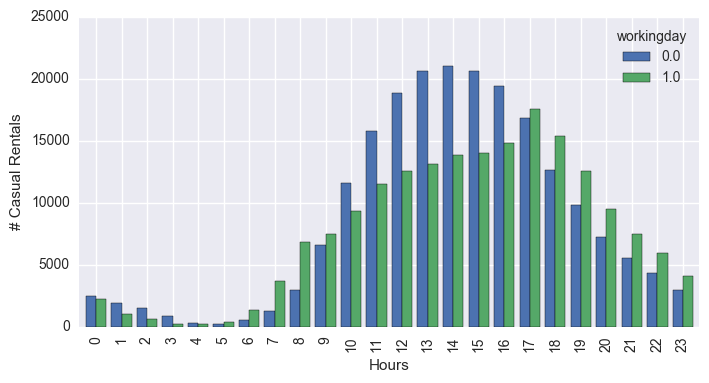

In [38]:
# rentals by hour, split by working day (or not)
by_hour = df_complete[df_complete['dataset'] == 'train'].copy().groupby(['hour', 'workingday'])['casual'].agg('sum').unstack()

by_hour.plot(kind='bar', figsize=(8,4), width=0.8, label='rush hours');
plt.ylabel('# Casual Rentals')
plt.xlabel('Hours')

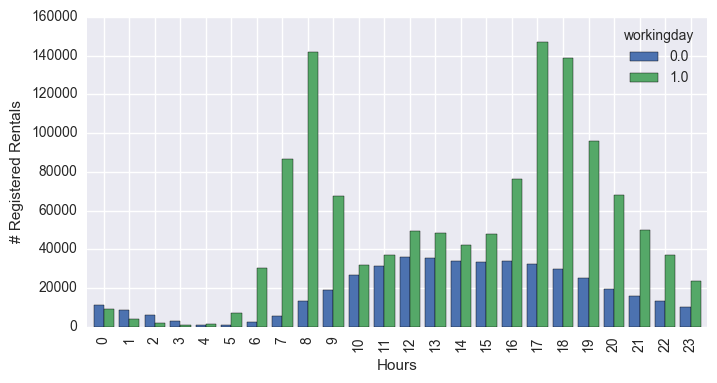

In [39]:
# rentals by hour, split by working day (or not)
by_hour = df_complete[df_complete['dataset'] == 'train'].copy().groupby(['hour', 'workingday'])['registered'].agg('sum').unstack()

by_hour.plot(kind='bar', figsize=(8,4), width=0.8);
plt.ylabel('# Registered Rentals')
plt.xlabel('Hours')

In [40]:
## Add Rush Hours according to histograms
df_complete['rush_hour_casual_man'] = df_complete[['hour', 'workingday']].apply(
    lambda x: (0, 1)[
        (x['workingday'] == 1 and  7 <= x['hour'] <= 23)
        or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)

df_complete['rush_hour_reg_man'] = df_complete[['hour', 'workingday']].apply(
    lambda x: (0, 1)[
        (x['workingday'] == 1 and  (6 <= x['hour'] <= 9 or 16 <= x['hour'] <= 23))
        or (x['workingday'] == 0 and  8 <= x['hour'] <= 23)], axis = 1)

In [41]:
# Getting rules for hour rushes
hour_dt = tree.DecisionTreeRegressor(max_depth=2)

dt_casual = df_complete[df_complete['dataset'] == 'train']['casual']
dt_registered = df_complete[df_complete['dataset'] == 'train']['registered']
dt_hour = df_complete[df_complete['dataset'] == 'train']['hour']

hour_dt.fit(dt_hour[:, None], dt_casual)
print 'Casual Temp:'
print tree_to_code(hour_dt, ['hour'])


hour_dt.fit(dt_hour[:, None], dt_registered)
print 'Registered Temp:'
print tree_to_code(hour_dt, ['hour'])

Casual Temp:
def sk_tree(hour):
  if hour <= 9.5:
    if hour <= 7.5:
      return [[ 5.29744018]]
    else:  # if hour > 7.5
      return [[ 26.24945055]]
  else:  # if hour > 9.5
    if hour <= 19.5:
      return [[ 66.27336551]]
    else:  # if hour > 19.5
      return [[ 25.84155702]]
None
Registered Temp:
def sk_tree(hour):
  if hour <= 6.5:
    if hour <= 5.5:
      return [[ 20.63785395]]
    else:  # if hour > 5.5
      return [[ 72.10989011]]
  else:  # if hour > 6.5
    if hour <= 20.5:
      return [[ 228.05141872]]
    else:  # if hour > 20.5
      return [[ 109.94078947]]
None


In [42]:
# Functions for defining the rush hours
def rush_hour_casual_bucket(hour):
  if hour <= 9.5:
    if hour <= 7.5:
      return 1
    else:  # if hour > 7.5
      return 2
  else:  # if hour > 9.5
    if hour <= 19.5:
      return 3
    else:  # if hour > 19.5
      return 4

def rush_hour_reg_bucket(hour):
  if hour <= 6.5:
    if hour <= 5.5:
      return 1
    else:  # if hour > 5.5
      return 2
  else:  # if hour > 6.5
    if hour <= 20.5:
      return 3
    else:  # if hour > 20.5
      return 4

In [43]:
df_complete['rush_hour_casual_aut'] = df_complete['hour'].apply(lambda x: rush_hour_casual_bucket(x))
df_complete['rush_hour_reg_aut'] = df_complete['hour'].apply(lambda x: rush_hour_reg_bucket(x))

### Rush Temperature

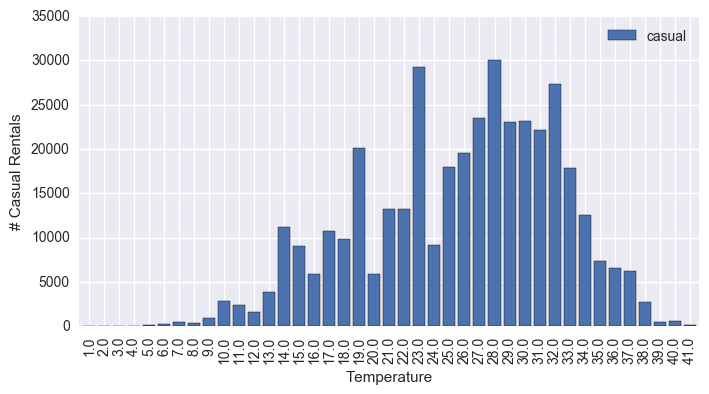

In [44]:
# casual rentals by temperature
by_hour = df_complete[df_complete['dataset'] == 'train'].copy().groupby(['temp'])['casual'].agg('sum')
by_hour = getGraphAxisByIntervals(by_hour, 1)

by_hour.plot(kind='bar', figsize=(8,4), width=0.8);
plt.ylabel('# Casual Rentals')
plt.xlabel('Temperature')

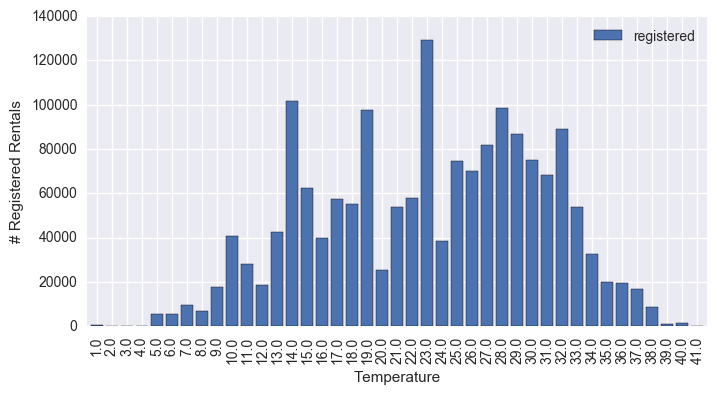

In [45]:
# registered rentals by temperature 
by_hour = df_complete[df_complete['dataset'] == 'train'].copy().groupby(['temp'])['registered'].agg('sum')
by_hour = getGraphAxisByIntervals(by_hour, 1)

by_hour.plot(kind='bar', figsize=(8,4), width=0.8);
plt.ylabel('# Registered Rentals')
plt.xlabel('Temperature')

In [46]:
#Add rush temps:
df_complete['rush_temp_casual_man'] = df_complete[['temp']].apply(
    lambda x: (0, 1)[
        (18.5 <= x['temp'] <= 19.5)
        or (22.5 <= x['temp'] <= 33)], axis = 1)
df_complete['rush_temp_reg_man'] = df_complete[['temp']].apply(
    lambda x: (0, 1)[
        (13.5 <= x['temp'] <= 15)
        or (18.5 <= x['temp'] <= 19.5)
        or (22 <= x['temp'] <= 23.5)
        or (27 <= x['temp'] <= 32)], axis = 1)

In [47]:
# Getting rules for temp rushes
temp_dt = tree.DecisionTreeRegressor(max_depth=3)

dt_casual = df_complete[df_complete['dataset'] == 'train']['casual']
dt_registered = df_complete[df_complete['dataset'] == 'train']['registered']
dt_temp = df_complete[df_complete['dataset'] == 'train']['temp']

temp_dt.fit(dt_temp[:, None], dt_casual)
print 'Casual Temp:'
print tree_to_code(temp_dt, ['temp'])

temp_dt.fit(dt_temp[:, None], dt_registered)
print 'Registered Temp:'
print tree_to_code(temp_dt, ['temp'])

Casual Temp:
def sk_tree(temp):
  if temp <= 23.3699989319:
    if temp <= 15.1700000763:
      if temp <= 12.7100000381:
        return [[ 5.95595735]]
      else:  # if temp > 12.7100000381
        return [[ 16.42799353]]
    else:  # if temp > 15.1700000763
      if temp <= 19.2700004578:
        return [[ 26.68481375]]
      else:  # if temp > 19.2700004578
        return [[ 37.16898008]]
  else:  # if temp > 23.3699989319
    if temp <= 29.9300003052:
      if temp <= 29.1100006104:
        return [[ 49.47193264]]
      else:  # if temp > 29.1100006104
        return [[ 65.60339943]]
    else:  # if temp > 29.9300003052
      if temp <= 32.3899993896:
        return [[ 77.61971831]]
      else:  # if temp > 32.3899993896
        return [[ 90.39504132]]
None
Registered Temp:
def sk_tree(temp):
  if temp <= 22.5499992371:
    if temp <= 12.7100000381:
      if temp <= 11.0699996948:
        return [[ 72.58390949]]
      else:  # if temp > 11.0699996948
        return [[ 107.50353357

In [48]:
# Functions for defining the temp rushes
def rush_temp_casual_bucket(temp):
  if temp <= 23.3699989319:
    if temp <= 15.1700000763:
      if temp <= 12.7100000381:
        return 1
      else:  # if temp > 12.7100000381
        return 2
    else:  # if temp > 15.1700000763
      if temp <= 19.2700004578:
        return 3
      else:  # if temp > 19.2700004578
        return 4
  else:  # if temp > 23.3699989319
    if temp <= 29.9300003052:
      if temp <= 29.1100006104:
        return 5
      else:  # if temp > 29.1100006104
        return 6
    else:  # if temp > 29.9300003052
      if temp <= 32.3899993896:
        return 7
      else:  # if temp > 32.3899993896
        return 8

def rush_temp_registered_bucket(temp):
  if temp <= 22.5499992371:
    if temp <= 12.7100000381:
      if temp <= 11.0699996948:
        return 1
      else:  # if temp > 11.0699996948
        return 2
    else:  # if temp > 12.7100000381
      if temp <= 19.2700004578:
        return 3
      else:  # if temp > 19.2700004578
        return 4
  else:  # if temp > 22.5499992371
    if temp <= 29.9300003052:
      if temp <= 28.2900009155:
        return 5
      else:  # if temp > 28.2900009155
        return 6
    else:  # if temp > 29.9300003052
      if temp <= 30.75:
        return 7
      else:  # if temp > 30.75
        return 8

In [49]:
df_complete['rush_temp_casual_aut'] = df_complete['temp'].apply(lambda x: rush_temp_casual_bucket(x))
df_complete['rush_temp_reg_aut'] = df_complete['temp'].apply(lambda x: rush_temp_registered_bucket(x))

### Rush Humidity

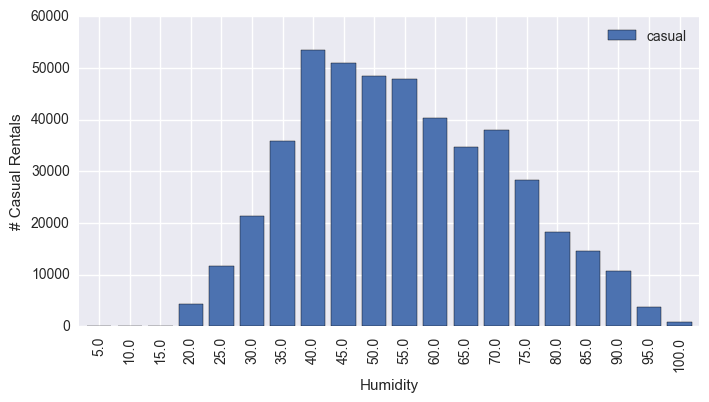

In [50]:
# casual rentals by humidity
by_hour = df_complete[df_complete['dataset'] == 'train'].copy().groupby(['humidity'])['casual'].agg('sum')
by_hour = getGraphAxisByIntervals(by_hour, 5)

by_hour.plot(kind='bar', figsize=(8,4), width=0.8);
plt.ylabel('# Casual Rentals')
plt.xlabel('Humidity')

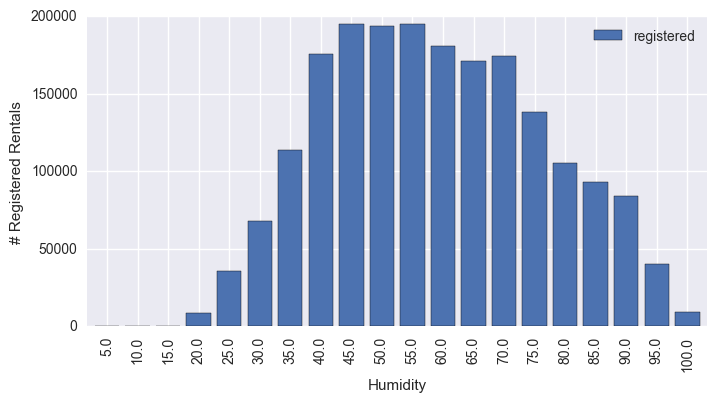

In [51]:
# registered rentals by humidity
by_hour = df_complete[df_complete['dataset'] == 'train'].copy().groupby(['humidity'])['registered'].agg('sum')
by_hour = getGraphAxisByIntervals(by_hour, 5)

by_hour.plot(kind='bar', figsize=(8,4), width=0.8);
plt.ylabel('# Registered Rentals')
plt.xlabel('Humidity')

In [52]:
#Add rush humidity:
df_complete['rush_humid_casual_man'] = df_complete[['humidity']].apply(
    lambda x: (0, 1)[
        (34 <= x['humidity'] <= 56)], axis = 1)
df_complete['rush_humid_reg_man'] = df_complete[['humidity']].apply(
    lambda x: (0, 1)[
        (39 <= x['humidity'] <= 66)], axis = 1)

In [53]:
# Getting rules for humidity rushes
humidity_dt = tree.DecisionTreeRegressor(max_depth=2)

dt_casual = df_complete[df_complete['dataset'] == 'train']['casual']
dt_registered = df_complete[df_complete['dataset'] == 'train']['registered']
dt_humidity = df_complete[df_complete['dataset'] == 'train']['humidity']

humidity_dt.fit(dt_humidity[:, None], dt_casual)
print 'Casual Humidity:'
print tree_to_code(humidity_dt, ['humidity'])

humidity_dt.fit(dt_humidity[:, None], dt_registered)
print 'Registered Humidity:'
print tree_to_code(humidity_dt, ['humidity'])

Casual Humidity:
def sk_tree(humidity):
  if humidity <= 55.5:
    if humidity <= 39.5:
      return [[ 69.760707]]
    else:  # if humidity > 39.5
      return [[ 46.30662021]]
  else:  # if humidity > 55.5
    if humidity <= 74.5:
      return [[ 32.4573481]]
    else:  # if humidity > 74.5
      return [[ 15.03651685]]
None
Registered Humidity:
def sk_tree(humidity):
  if humidity <= 66.5:
    if humidity <= 43.5:
      return [[ 215.93435754]]
    else:  # if humidity > 43.5
      return [[ 169.73187023]]
  else:  # if humidity > 66.5
    if humidity <= 84.5:
      return [[ 127.86905949]]
    else:  # if humidity > 84.5
      return [[ 86.68835394]]
None


In [54]:
# Functions for defining the humidity rushes
def rush_humid_casual_bucket(humidity):
  if humidity <= 55.5:
    if humidity <= 39.5:
      return 1
    else:  # if humidity > 39.5
      return 2
  else:  # if humidity > 55.5
    if humidity <= 74.5:
      return 3
    else:  # if humidity > 74.5
      return 4

def rush_humid_reg_bucket(humidity):
  if humidity <= 66.5:
    if humidity <= 43.5:
      return 1
    else:  # if humidity > 43.5
      return 2
  else:  # if humidity > 66.5
    if humidity <= 84.5:
      return 3
    else:  # if humidity > 84.5
      return 4

In [55]:
df_complete['rush_humid_casual_aut'] = df_complete['humidity'].apply(lambda x: rush_humid_casual_bucket(x))
df_complete['rush_humid_reg_aut'] = df_complete['humidity'].apply(lambda x: rush_humid_reg_bucket(x))

### Rush Windspeed

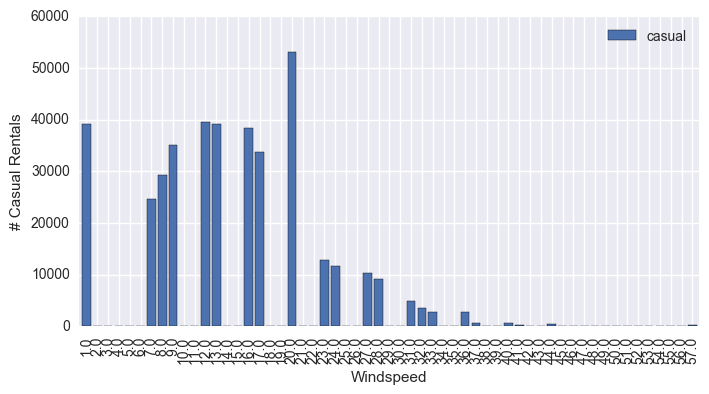

In [56]:
# casual rentals by windspeed
by_hour = df_complete[df_complete['dataset'] == 'train'].copy().groupby(['windspeed'])['casual'].agg('sum')
by_hour = getGraphAxisByIntervals(by_hour, 1)

by_hour.plot(kind='bar', figsize=(8,4), width=0.8);
plt.ylabel('# Casual Rentals')
plt.xlabel('Windspeed')

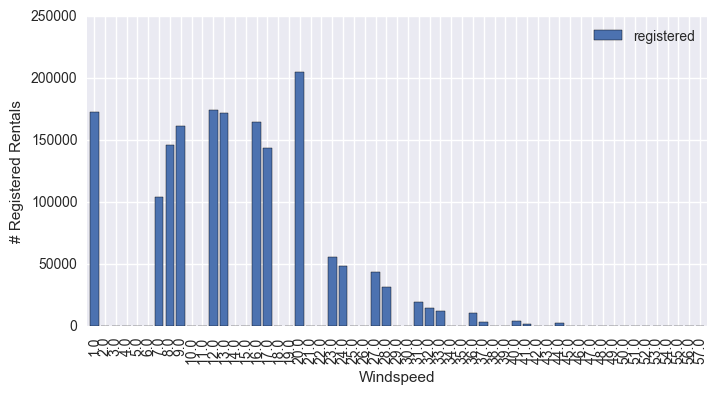

In [57]:
# casual rentals by windspeed
by_hour = df_complete[df_complete['dataset'] == 'train'].copy().groupby(['windspeed'])['registered'].agg('sum')
by_hour = getGraphAxisByIntervals(by_hour, 1)

by_hour.plot(kind='bar', figsize=(8,4), width=0.8);
plt.ylabel('# Registered Rentals')
plt.xlabel('Windspeed')

In [58]:
#Add rush humidity:
df_complete['rush_wind_casual_man'] = df_complete[['windspeed']].apply(
    lambda x: (0, 1)[
        (x['windspeed'] <= 21)], axis = 1)
df_complete['rush_wind_reg_man'] = df_complete[['windspeed']].apply(
    lambda x: (0, 1)[
        (x['windspeed'] <= 21)], axis = 1)

In [59]:
# Getting rules for wind rushes
wind_dt = tree.DecisionTreeRegressor(max_depth=2)

dt_casual = df_complete[df_complete['dataset'] == 'train']['casual']
dt_registered = df_complete[df_complete['dataset'] == 'train']['registered']
dt_wind = df_complete[df_complete['dataset'] == 'train']['windspeed']

wind_dt.fit(dt_wind[:, None], dt_casual)
print 'Casual Wind:'
print tree_to_code(wind_dt, ['windspeed'])

wind_dt.fit(dt_wind[:, None], dt_registered)
print 'Registered Wind:'
print tree_to_code(wind_dt, ['windspeed'])

Casual Wind:
def sk_tree(windspeed):
  if windspeed <= 9.99975013733:
    if windspeed <= 7.99980020523:
      return [[ 28.92171482]]
    else:  # if windspeed > 7.99980020523
      return [[ 31.25625]]
  else:  # if windspeed > 9.99975013733
    if windspeed <= 15.9995994568:
      return [[ 38.18856209]]
    else:  # if windspeed > 15.9995994568
      return [[ 42.20590766]]
None
Registered Wind:
def sk_tree(windspeed):
  if windspeed <= 9.99975013733:
    if windspeed <= 6.50234985352:
      return [[ 126.62883295]]
    else:  # if windspeed > 6.50234985352
      return [[ 143.00092851]]
  else:  # if windspeed > 9.99975013733
    if windspeed <= 41.9989471436:
      return [[ 169.56336299]]
    else:  # if windspeed > 41.9989471436
      return [[ 117.89655172]]
None


In [60]:
def rush_wind_casual_bucket(windspeed):
  if windspeed <= 9.99975013733:
    if windspeed <= 7.99980020523:
      return 1
    else:  # if windspeed > 7.99980020523
      return 2
  else:  # if windspeed > 9.99975013733
    if windspeed <= 15.9995994568:
      return 3
    else:  # if windspeed > 15.9995994568
      return 4

def rush_wind_reg_bucket(windspeed):
  if windspeed <= 9.99975013733:
    if windspeed <= 6.50234985352:
      return 1
    else:  # if windspeed > 6.50234985352
      return 2
  else:  # if windspeed > 9.99975013733
    if windspeed <= 41.9989471436:
      return 3
    else:  # if windspeed > 41.9989471436
      return 4

In [61]:
df_complete['rush_wind_casual_aut'] = df_complete['windspeed'].apply(lambda x: rush_wind_casual_bucket(x))
df_complete['rush_wind_reg_aut'] = df_complete['windspeed'].apply(lambda x: rush_wind_reg_bucket(x))

### Complementing Holidays Features

In [62]:
## Adding some missed "holydays"

#storms
df_complete.loc[get_day_range(pd.datetime(2012, 5, 21)), "workingday"] = 0
df_complete.loc[get_day_range(pd.datetime(2012, 5, 21)), "holiday"] = 1

#tornado
df_complete.loc[get_day_range(pd.datetime(2012, 6, 1)), "workingday"] = 0
df_complete.loc[get_day_range(pd.datetime(2012, 6, 1)), "holiday"] = 1

# tax day
df_complete.loc[get_day_range(pd.datetime(2011, 4, 15)), "workingday"] = 1
df_complete.loc[get_day_range(pd.datetime(2012, 4, 16)), "workingday"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 4, 15)), "holiday"] = 0
df_complete.loc[get_day_range(pd.datetime(2012, 4, 16)), "holiday"] = 0

# thanksgiving friday
df_complete.loc[get_day_range(pd.datetime(2011, 11, 25)), "workingday"] = 0
df_complete.loc[get_day_range(pd.datetime(2012, 11, 23)), "workingday"] = 0
df_complete.loc[get_day_range(pd.datetime(2011, 11, 25)), "holiday"] = 1
df_complete.loc[get_day_range(pd.datetime(2012, 11, 23)), "holiday"] = 1

#Christmas eve
df_complete.loc[get_day_range(pd.datetime(2011, 12, 24)), "holiday"] = 1
df_complete.loc[get_day_range(pd.datetime(2012, 12, 24)), "holiday"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 12, 24)), "workingday"] = 0
df_complete.loc[get_day_range(pd.datetime(2012, 12, 24)), "workingday"] = 0

#New year's eve
df_complete.loc[get_day_range(pd.datetime(2011, 12, 31)), "holiday"] = 1
df_complete.loc[get_day_range(pd.datetime(2012, 12, 31)), "holiday"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 12, 31)), "workingday"] = 0
df_complete.loc[get_day_range(pd.datetime(2012, 12, 31)), "workingday"] = 0

# Correlation Matrix

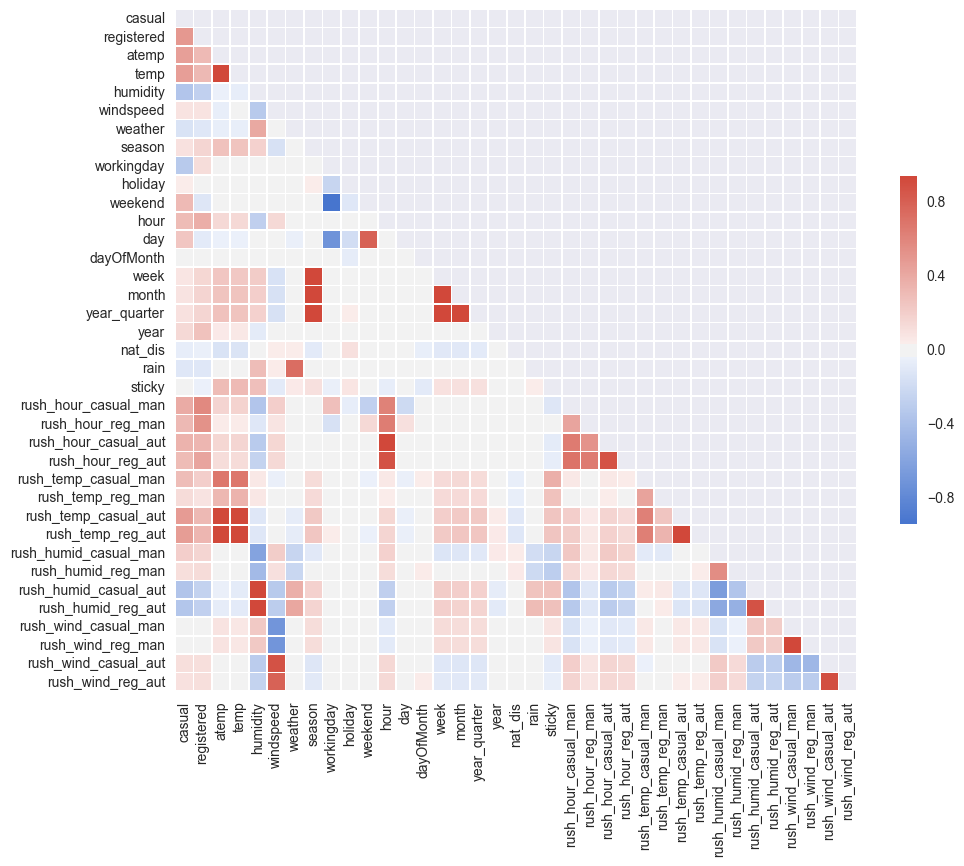

In [65]:
# Compute the correlation matrix
plot_cols = ['casual', 'registered', 'atemp', 'temp', 'humidity', 'windspeed', 'weather', 'season',
                'workingday', 'holiday', 'weekend', 'hour', 'day', 'dayOfMonth', 'week', 'month',
                'year_quarter', 'year',  'nat_dis', 'rain', 'sticky', 'rush_hour_casual_man',
                'rush_hour_reg_man', 'rush_hour_casual_aut', 'rush_hour_reg_aut',
                'rush_temp_casual_man', 'rush_temp_reg_man', 'rush_temp_casual_aut', 
                'rush_temp_reg_aut', 'rush_humid_casual_man', 'rush_humid_reg_man',
                'rush_humid_casual_aut', 'rush_humid_reg_aut', 'rush_wind_casual_man',
                'rush_wind_reg_man','rush_wind_casual_aut', 'rush_wind_reg_aut']
corr = df_complete[df_complete['dataset'] == 'train'][plot_cols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(256, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

# Contruct Full Training and Testing Sets

In [68]:
# Variable that indicates if log counts should be used
use_log = True

In [69]:
#Construct the full kaggle training set
df_train_full = df_complete[df_complete['dataset'] == 'train']
del df_train_full['dataset']

df_train_full_y_c = df_train_full['log_casual'].values if use_log else df_train_full['casual'].values
df_train_full_y_r = df_train_full['log_registered'].values if use_log else df_train_full['registered'].values

df_train_full_x = df_train_full.drop(['casual', 'registered', 'log_casual', 'log_registered'],axis = 1)#.values

In [70]:
#Construct the full kaggle testing set
df_test_full = df_complete[df_complete['dataset'] == 'test']
del df_test_full['dataset']
#del df_test['count']
del df_test_full['casual']
del df_test_full['registered']

In [71]:
# Split the full training set into training and validations set
train_x, train_y_c, train_y_r, val_x, val_y_c, val_y_r = splitTrainingTesting(df_train_full, use_log, 0.3)
train_y = getSumRentals(train_y_c, train_y_r, use_log)
val_y = getSumRentals(val_y_c, val_y_r, use_log)

# Feature Selection

In [72]:
#These are the basic features both registered and casual rentals should use.
basic_features = ['humidity', 'atemp', 'temp', 'windspeed', 'weather', 'season', 'holiday', 
                  'workingday', 'weekend', 'day', 'hour']

#The test features are the ones that are derived from the basic features and we'll check if they improve 
# or not our predictions
to_test_features = ['year_quarter', 'month', 'week', 'nat_dis', 'rain', 'sticky']

to_test_features_casual = to_test_features + ['rush_hour_casual_man', 'rush_hour_casual_aut', 'rush_temp_casual_man',
                                            'rush_temp_casual_aut', 'rush_humid_casual_man', 'rush_humid_casual_aut', 
                                            'rush_wind_casual_man', 'rush_wind_casual_aut']
to_test_features_reg = to_test_features + ['rush_hour_reg_man', 'rush_hour_reg_aut', 'rush_temp_reg_man',
                                           'rush_temp_reg_aut', 'rush_humid_reg_man', 'rush_humid_reg_aut', 
                                           'rush_wind_reg_man', 'rush_wind_reg_aut']

In [73]:
# Train and predict basic models with basic features  
xgb_pred_train, xgb_pred_test = predictWithModel(xgb.XGBRegressor(), train_x, train_y_c, train_y_r, val_x, 
                            basic_features, basic_features, use_log)

# Calculate the RMSLE Score
scoreXgb_train = rmsle(train_y, xgb_pred_train)
scoreXgb_test = rmsle(val_y, xgb_pred_test)
print 'XGB\t', 'Basic Features\t', scoreXgb_train, '\t', scoreXgb_test

#Predict with full data set and print the file so we check with kaggle
_, xgb_pred_full = predictWithModel(xgb.XGBRegressor(), df_train_full, df_train_full_y_c, df_train_full_y_r, df_test_full, 
                                    basic_features, basic_features, use_log)
printPrediction(xgb_pred_full, 'xgb-BASIC.csv')

XGB	Basic Features	0.328974706168 	0.356089237307


In [74]:
#Iterate over all the to_test features
for i in range(len(to_test_features_casual)):

    #Current features for both casual and registered
    current_casual_features = basic_features + [to_test_features_casual[i]]
    current_reg_features = basic_features + [to_test_features_reg[i]]
    
    #Train and predict basic models    
    xgb_pred_train, xgb_pred_test = predictWithModel(xgb.XGBRegressor(), train_x, train_y_c, train_y_r, val_x, 
                                        current_casual_features, current_reg_features, use_log)
    
    #Name of the current feature for printing
    strCurrentFeature = to_test_features_reg[i] if to_test_features_casual[i] == to_test_features_reg[i] else to_test_features_casual[i] + '-' + to_test_features_reg[i]

    # Calculate the RMSLE Score
    scoreXgb_train = rmsle(train_y, xgb_pred_train)
    scoreXgb_test = rmsle(val_y, xgb_pred_test)
    print 'XGB\t', 'With ' + strCurrentFeature + '\t', scoreXgb_train, '\t', scoreXgb_test
    
    #Predict with full data set and print the file so we check with kaggle
    _, xgb_pred_full = predictWithModel(xgb.XGBRegressor(), df_train_full, df_train_full_y_c, df_train_full_y_r, df_test_full, 
                                        current_casual_features, current_reg_features, use_log)
    printPrediction(xgb_pred_full, 'xgb-' + strCurrentFeature + '.csv')

XGB	With year_quarter	0.328974706168 	0.356089237307
XGB	With month	0.325947990808 	0.34995302574
XGB	With week	0.326428419252 	0.353829717661
XGB	With nat_dis	0.331873578605 	0.35938026432
XGB	With rain	0.328974706168 	0.356089237307
XGB	With sticky	0.329432907215 	0.356718747315
XGB	With rush_hour_casual_man-rush_hour_reg_man	0.323757361005 	0.35090478295
XGB	With rush_hour_casual_aut-rush_hour_reg_aut	0.328974706168 	0.356089237307
XGB	With rush_temp_casual_man-rush_temp_reg_man	0.328526897196 	0.355683418567
XGB	With rush_temp_casual_aut-rush_temp_reg_aut	0.328974706168 	0.356089237307
XGB	With rush_humid_casual_man-rush_humid_reg_man	0.328290494772 	0.355489418908
XGB	With rush_humid_casual_aut-rush_humid_reg_aut	0.328974706168 	0.356089237307
XGB	With rush_wind_casual_man-rush_wind_reg_man	0.328974706168 	0.356089237307
XGB	With rush_wind_casual_aut-rush_wind_reg_aut	0.328974706168 	0.356089237307


## Final Features to use

In [75]:
# FEATURES TO USE
features_common = ['humidity', 'atemp', 'temp', 'windspeed', 'weather', 'season', 'holiday', 
                      'workingday', 'weekend', 'day', 'hour', 'nat_dis', 'sticky']

features_casual = features_common + ['rush_hour_casual_man', 'rush_temp_casual_man', 'rush_humid_casual_man']
features_registered = features_common + ['rush_hour_reg_man', 'rush_temp_reg_man', 'rush_humid_reg_man']

# Models

### Cross Validation Generator

In [76]:
# Cross Validation Generator
cv = cross_validation.ShuffleSplit(len(df_train_full_x), n_iter=3, test_size=0.2,
    random_state=0)

## Decision Tree

### Parameter Tunning

In [77]:
#Parameters to check
tuned_parameters = [
    {'max_depth':[9,10,11,20,25,50]},
    {'min_samples_leaf':[1,2,5,10,50,100]},
    {'min_samples_split':[1,2,5,10,50,100]},
    {'presort':[True, False]},
    {'min_weight_fraction_leaf':[0.0, 0.1, 0.3, 0.4, 0.5]}]   
    
#Parameter tunning
parameterTunning(tree.DecisionTreeRegressor(), tuned_parameters, train_x, val_x, train_y, val_y)

Best parameters set found on development set:
DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

Grid scores on development set:

0.627 (+/-0.102) for {'max_depth': 9}
0.627 (+/-0.091) for {'max_depth': 10}
0.588 (+/-0.103) for {'max_depth': 11}
0.574 (+/-0.098) for {'max_depth': 20}
0.563 (+/-0.095) for {'max_depth': 25}
0.578 (+/-0.093) for {'max_depth': 50}
0.579 (+/-0.094) for {'min_samples_leaf': 1}
0.591 (+/-0.102) for {'min_samples_leaf': 2}
0.615 (+/-0.106) for {'min_samples_leaf': 5}
0.617 (+/-0.111) for {'min_samples_leaf': 10}
0.514 (+/-0.138) for {'min_samples_leaf': 50}
0.456 (+/-0.144) for {'min_samples_leaf': 100}
0.577 (+/-0.099) for {'min_samples_split': 1}
0.563 (+/-0.096) for {'min_samples_split': 2}
0.588 (+/-0.093) for {'min_samples_split': 5}
0.606 (+/-0.107) for {'min_s

In [78]:
# Best Model
dtr = tree.DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

### Cross Validation

In [79]:
# Cross Validation
crossValidationForModel(dtr, df_train_full_x, df_train_full_y_c, df_train_full_y_r,
                        features_casual, features_registered, use_log, cv)

Train RMSLE: 0.275, Validation RMSLE: 0.357

Train RMSLE: 0.278, Validation RMSLE: 0.347

Train RMSLE: 0.278, Validation RMSLE: 0.358



### Predicting and Exporting File

In [80]:
# Predicting & Exporting File
_, dtr_pred = predictWithModel(dtr, df_train_full_x, df_train_full_y_c, df_train_full_y_r, df_test_full, 
                            features_casual, features_registered, use_log)

printPrediction(dtr_pred)

## Random Forest

### Parameter Tunning

In [85]:
#Parameters to check
tuned_parameters = [
    {'max_depth':[50,100, 500, 1000]}, #Best: 1000
    {'n_estimators':[1000, 5000]}, #We assume is 1000
    {'min_samples_leaf':[1,2,5,10,50,100]}, #2
    {'min_samples_split':[1,2,5,10,50,100]}, #10
    {'min_weight_fraction_leaf':[0.0, 0.1, 0.3, 0.4, 0.5]}] #0.0    
    
#Parameter tunning
parameterTunning(RandomForestRegressor(), tuned_parameters, train_x, val_x, train_y, val_y)

Best parameters set found on development set:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=1, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Grid scores on development set:

0.672 (+/-0.108) for {'max_depth': 50}
0.675 (+/-0.110) for {'max_depth': 100}
0.679 (+/-0.111) for {'max_depth': 500}
0.668 (+/-0.110) for {'max_depth': 1000}
0.701 (+/-0.104) for {'n_estimators': 1000}
0.699 (+/-0.105) for {'n_estimators': 5000}
0.676 (+/-0.118) for {'min_samples_leaf': 1}
0.673 (+/-0.113) for {'min_samples_leaf': 2}
0.673 (+/-0.108) for {'min_samples_leaf': 5}
0.658 (+/-0.111) for {'min_samples_leaf': 10}
0.536 (+/-0.128) for {'min_samples_leaf': 50}
0.480 (+/-0.118) for {'min_samples_leaf': 100}
0.702 (+/-0.099) for {'min_samples_split': 1}
0.683 (+/-0.104) for {'min_sampl

In [86]:
#Optimized model
rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1000,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=2,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

### Cross Validation

In [87]:
# Cross Validation
crossValidationForModel(rfr, df_train_full_x, df_train_full_y_c, df_train_full_y_r,
                        features_casual, features_registered, use_log, cv)

Train RMSLE: 0.208, Validation RMSLE: 0.314

Train RMSLE: 0.208, Validation RMSLE: 0.307

Train RMSLE: 0.209, Validation RMSLE: 0.308



### Predicting and Exporting File

In [88]:
# Predicting Year by Year
_, rfr_pred = predictWithModel(rfr, df_train_full_x, df_train_full_y_c, df_train_full_y_r, df_test_full, 
                            features_casual, features_registered, use_log)
printPrediction(rfr_pred)

## XGBoost Regressor

### Parameter Tunning

In [89]:
# Parameters to check
tuned_parameters = [
    {'max_depth': [2,5,10,100,1000]}, # best 100
    {'n_estimators': [50,100,500,1000,5000,10000]}, # best 5000
    {'learning_rate': [0.15, 0.18, 0.2, 0.29, 0.3]}]  #best 0.2
    
    
#Parameter tunning
parameterTunning(xgb.XGBRegressor(), tuned_parameters, train_x, val_x, train_y, val_y)

Best parameters set found on development set:
XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

Grid scores on development set:

0.637 (+/-0.110) for {'max_depth': 2}
0.741 (+/-0.113) for {'max_depth': 5}
0.753 (+/-0.087) for {'max_depth': 10}
0.753 (+/-0.077) for {'max_depth': 100}
0.753 (+/-0.077) for {'max_depth': 1000}
0.606 (+/-0.124) for {'n_estimators': 50}
0.676 (+/-0.113) for {'n_estimators': 100}
0.751 (+/-0.094) for {'n_estimators': 500}
0.773 (+/-0.087) for {'n_estimators': 1000}
0.744 (+/-0.108) for {'n_estimators': 5000}
0.724 (+/-0.113) for {'n_estimators': 10000}
0.707 (+/-0.109) for {'learning_rate': 0.15}
0.723 (+/-0.100) for {'learning_rate': 0.18}
0.733 (+/-0.092) for {'learning_rate': 0.2}
0.

In [90]:
#Optimized model
xgbr = XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.2, max_delta_step=0, max_depth=1000,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

### Cross Validation

In [91]:
# Cross Validation
crossValidationForModel(xgbr, df_train_full_x, df_train_full_y_c, df_train_full_y_r, 
                        features_casual, features_registered, use_log, cv)

Train RMSLE: 0.015, Validation RMSLE: 0.316

Train RMSLE: 0.011, Validation RMSLE: 0.305

Train RMSLE: 0.006, Validation RMSLE: 0.307



### Predicting and Exporting File

In [92]:
# Predicting Year by Year
_, xgbr_pred = predictWithModel(xgbr, df_train_full_x, df_train_full_y_c, df_train_full_y_r, df_test_full, 
                            features_casual, features_registered, use_log)
printPrediction(xgbr_pred)

## Merging models

In [93]:
rfr_xgbr_merged_pred = 0.8 * rfr_pred + 0.2 * xgbr_pred
printPrediction(rfr_xgbr_merged_pred)

# Quick Run

In [94]:
features_common = ['humidity', 'atemp', 'temp', 'windspeed', 'weather', 'season', 'holiday', 
                  'workingday', 'weekend', 'day', 'hour', 'nat_dis', 'sticky']

features_casual = features_common + ['rush_hour_casual_man', 'rush_temp_casual_man', 'rush_humid_casual_man']
features_registered = features_common + ['rush_hour_reg_man', 'rush_temp_reg_man', 'rush_humid_reg_man']

In [95]:
_, rfr_pred = predictWithModel(rfr, df_train_full_x, df_train_full_y_c, df_train_full_y_r, df_test_full, 
                            features_casual, features_registered, use_log)
_, xgbr_pred = predictWithModel(xgbr, df_train_full_x, df_train_full_y_c, df_train_full_y_r, df_test_full, 
                            features_casual, features_registered, use_log)

In [96]:
for per_xgb in np.arange(0.05, 1, 0.05):
    per_rfr = 1 - per_xgb
    rfr_xgbr_merged_pred = per_rfr * rfr_pred + per_xgb * xgbr_pred
    fileName = 'merged_{}_{}.csv'.format(per_rfr, per_xgb)
    printPrediction(rfr_xgbr_merged_pred, fileName)